## Predictive Modelling with Random Forest on Road Accidents STATS19 dataset

<font color="orange">Dataset includes data from years 2010 to 2015 for training and 2016 for testing</font>

<font color="orange">Approach:   
1) Reviewed variables in the dataset to transform/derive new variables    
2) Distribution of data guided the choice of predictive model    
3) Train and test sets were used for model building; a separate hold-out test set from 2016 was also used for validation   
4) Class imbalance was resolved with undersampling   
5) Grid search was used for choosing best parameters   
6) Cross validation enabled model validation    
7) Performance was evaluated with ROC curve and confusion matrix</font> 

<font color="orange">Random Forest was chosen due to following reasons:      
1) Non-linearity in the dataset      
2) Presence of categorical variables      
3) Inability to draw much inferences on relationship between variables       
4) Preference for a non-parametric approach without much assumptions </font>

#### Load packages

In [1]:
import csv
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from pandas import ExcelWriter
from pandas import ExcelFile
from sklearn.preprocessing import LabelEncoder
import warnings
import pygeohash as pgh
from sklearn.cluster import KMeans
import matplotlib.cm as cm
from geopy.distance import great_circle
from geopy.distance import vincenty
from datetime import datetime
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.preprocessing import Imputer
from sklearn.metrics import classification_report
warnings.filterwarnings('ignore')
%matplotlib inline
get_ipython().magic('matplotlib inline')
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rc('xtick', labelsize=8) 
matplotlib.rc('ytick', labelsize=8)
np.random.seed(10)
%load_ext rpy2.ipython

C:\Users\Mithu\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Environment setting

In [2]:
startTime = datetime.now()
wd = "C://MEJ//Interviews//Sky//Data//"
os.chdir(wd)
del wd

#### Load pre-wrangled dataset

In [3]:
csvData = pd.read_csv("BinarySeverity2010_2015.csv")

#### Check for sparsity in dataset

In [4]:
print('Sparsity per variable in the dataset:')
((len(csvData.index) - csvData.count())/len(csvData.index))#Sparsity per variable retained

Sparsity per variable in the dataset:


Unnamed: 0                                 0.0
Vehicle_Reference                          0.0
Total Casualities                          0.0
Fatal                                      0.0
Serious                                    0.0
Slight                                     0.0
Pedestrian_Count                           0.0
Vehicle_Type                               0.0
Towing_and_Articulation                    0.0
Vehicle_Manoeuvre                          0.0
Vehicle_Location-Restricted_Lane           0.0
Junction_Location                          0.0
Skidding_and_Overturning                   0.0
Hit_Object_in_Carriageway                  0.0
Vehicle_Leaving_Carriageway                0.0
Hit_Object_off_Carriageway                 0.0
1st_Point_of_Impact                        0.0
Vehicle_Left_Hand_Drive                    0.0
Journey_Purpose_of_Driver                  0.0
Sex_of_Driver                              0.0
Age_of_Driver                              0.0
Age_Band_of_D

#### Data visualisation for assessing distribution of variables

##### Vehicle attributes

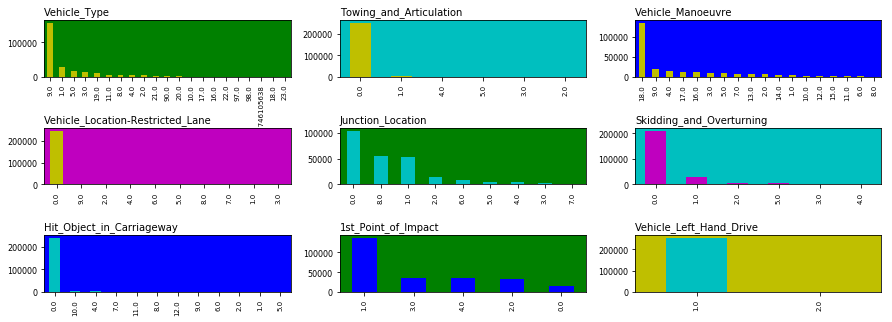

In [5]:
plt.figure(figsize=(15,5))
plt.subplot(331,facecolor='g')
pd.value_counts(csvData['Vehicle_Type']).plot.bar(color='y')#Attribute on x-axis
plt.title('Vehicle_Type',loc='left',fontsize=10)
plt.xticks(fontsize=7)
plt.subplot(332,facecolor='c')
pd.value_counts(csvData['Towing_and_Articulation']).plot.bar(color='y')#Attribute on x-axis
plt.title('Towing_and_Articulation',loc='left',fontsize=10)
plt.xticks(fontsize=7)
plt.subplot(333,facecolor='b')
pd.value_counts(csvData['Vehicle_Manoeuvre']).plot.bar(color='y')#Attribute on x-axis
plt.title('Vehicle_Manoeuvre',loc='left',fontsize=10)
plt.xticks(fontsize=7)
plt.subplot(334,facecolor='m')
pd.value_counts(csvData['Vehicle_Location-Restricted_Lane']).plot.bar(color='y')#Attribute on x-axis
plt.title('Vehicle_Location-Restricted_Lane',loc='left',fontsize=10)
plt.xticks(fontsize=7)
plt.subplot(335,facecolor='g')
pd.value_counts(csvData['Junction_Location']).plot.bar(color='c')#Attribute on x-axis
plt.title('Junction_Location',loc='left',fontsize=10)
plt.xticks(fontsize=7)
plt.subplot(336,facecolor='c')
pd.value_counts(csvData['Skidding_and_Overturning']).plot.bar(color='m')#Attribute on x-axis
plt.title('Skidding_and_Overturning',loc='left',fontsize=10)
plt.xticks(fontsize=7)
plt.subplot(337,facecolor='b')
pd.value_counts(csvData['Hit_Object_in_Carriageway']).plot.bar(color='c')#Attribute on x-axis
plt.title('Hit_Object_in_Carriageway',loc='left',fontsize=10)
plt.xticks(fontsize=7)
plt.subplot(338,facecolor='g')
pd.value_counts(csvData['1st_Point_of_Impact']).plot.bar(color='b')#Attribute on x-axis
plt.title('1st_Point_of_Impact',loc='left',fontsize=10)
plt.xticks(fontsize=7)
plt.subplot(339,facecolor='y')
pd.value_counts(csvData['Vehicle_Left_Hand_Drive']).plot.bar(color='c')#Attribute on x-axis
plt.title('Vehicle_Left_Hand_Drive',loc='left',fontsize=10)
plt.xticks(fontsize=7)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.9)
plt.show()

##### Driver attributes

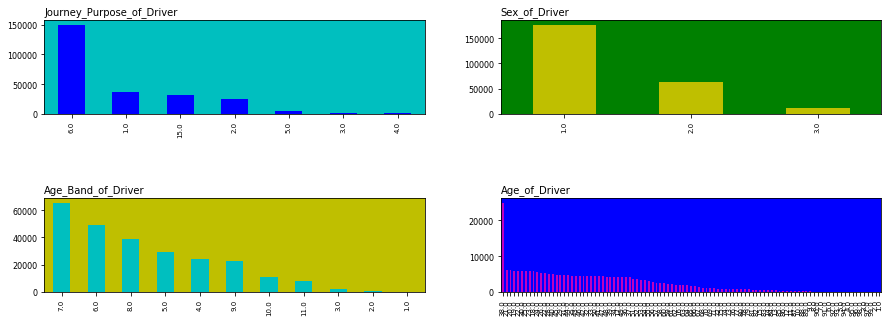

In [6]:
plt.figure(figsize=(15,5))
plt.subplot(221,facecolor='c')
pd.value_counts(csvData['Journey_Purpose_of_Driver']).plot.bar(color='b')#Attribute on x-axis
plt.title('Journey_Purpose_of_Driver',loc='left',fontsize=10)
plt.xticks(fontsize=7)
plt.subplot(222,facecolor='g')
pd.value_counts(csvData['Sex_of_Driver']).plot.bar(color='y')#Attribute on x-axis
plt.title('Sex_of_Driver',loc='left',fontsize=10)
plt.xticks(fontsize=7)
plt.subplot(223,facecolor='y')
pd.value_counts(csvData['Age_Band_of_Driver']).plot.bar(color='c')#Attribute on x-axis
plt.title('Age_Band_of_Driver',loc='left',fontsize=10)
plt.xticks(fontsize=7)
plt.subplot(224,facecolor='b')
pd.value_counts(csvData['Age_of_Driver']).plot.bar(color='m')#Attribute on x-axis
plt.title('Age_of_Driver',loc='left',fontsize=10)
plt.xticks(fontsize=7)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.9)
plt.show()

##### Pedestrian attributes

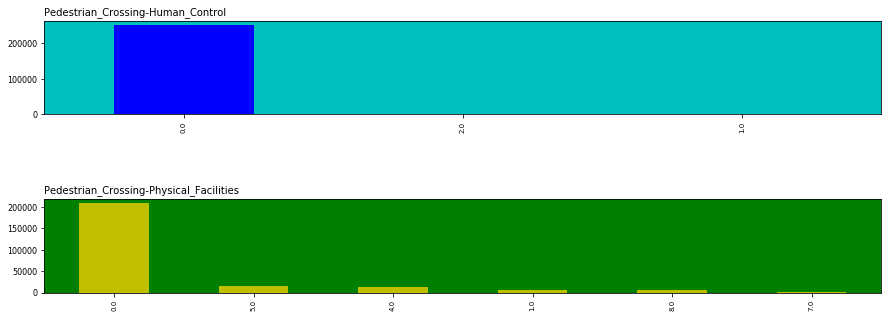

In [7]:
plt.figure(figsize=(15,5))
plt.subplot(211,facecolor='c')
pd.value_counts(csvData['Pedestrian_Crossing-Human_Control']).plot.bar(color='b')#Attribute on x-axis
plt.title('Pedestrian_Crossing-Human_Control',loc='left',fontsize=10)
plt.xticks(fontsize=7)
plt.subplot(212,facecolor='g')
pd.value_counts(csvData['Pedestrian_Crossing-Physical_Facilities']).plot.bar(color='y')#Attribute on x-axis
plt.title('Pedestrian_Crossing-Physical_Facilities',loc='left',fontsize=10)
plt.xticks(fontsize=7)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.9)
plt.show()

##### Road attributes

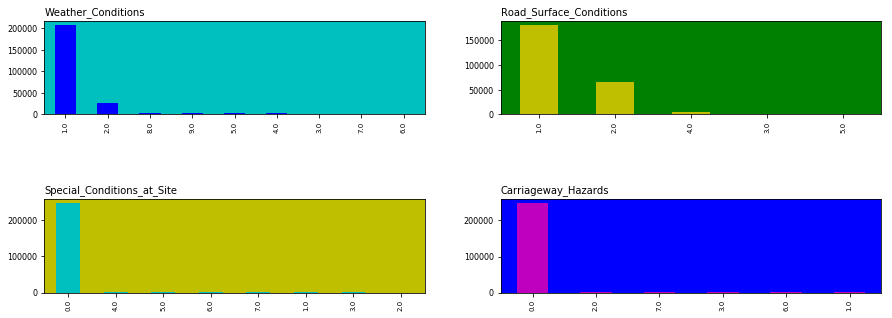

In [8]:
plt.figure(figsize=(15,5))
plt.subplot(221,facecolor='c')
pd.value_counts(csvData['Weather_Conditions']).plot.bar(color='b')#Attribute on x-axis
plt.title('Weather_Conditions',loc='left',fontsize=10)
plt.xticks(fontsize=7)
plt.subplot(222,facecolor='g')
pd.value_counts(csvData['Road_Surface_Conditions']).plot.bar(color='y')#Attribute on x-axis
plt.title('Road_Surface_Conditions',loc='left',fontsize=10)
plt.xticks(fontsize=7)
plt.subplot(223,facecolor='y')
pd.value_counts(csvData['Special_Conditions_at_Site']).plot.bar(color='c')#Attribute on x-axis
plt.title('Special_Conditions_at_Site',loc='left',fontsize=10)
plt.xticks(fontsize=7)
plt.subplot(224,facecolor='b')
pd.value_counts(csvData['Carriageway_Hazards']).plot.bar(color='m')#Attribute on x-axis
plt.title('Carriageway_Hazards',loc='left',fontsize=10)
plt.xticks(fontsize=7)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.9)
plt.show()

#### Variable datatype

In [9]:
print('Datatype of variables:')
csvData.dtypes#Checking variable data type as numeric type is most easy to deal with

Datatype of variables:


Unnamed: 0                                   int64
Vehicle_Reference                            int64
Total Casualities                            int64
Fatal                                        int64
Serious                                      int64
Slight                                       int64
Pedestrian_Count                             int64
Vehicle_Type                               float64
Towing_and_Articulation                    float64
Vehicle_Manoeuvre                          float64
Vehicle_Location-Restricted_Lane           float64
Junction_Location                          float64
Skidding_and_Overturning                   float64
Hit_Object_in_Carriageway                  float64
Vehicle_Leaving_Carriageway                float64
Hit_Object_off_Carriageway                 float64
1st_Point_of_Impact                        float64
Vehicle_Left_Hand_Drive                    float64
Journey_Purpose_of_Driver                  float64
Sex_of_Driver                  

#### Correlation

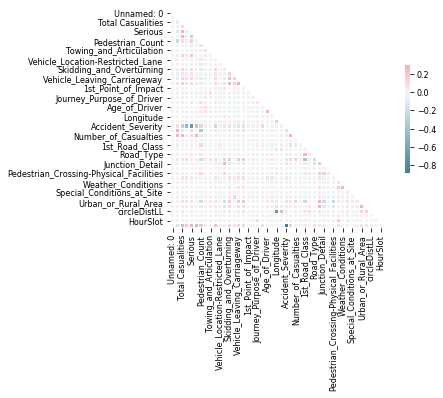

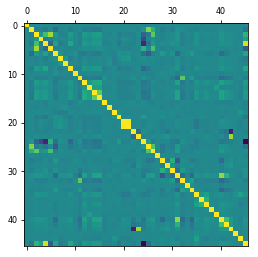

In [10]:
corr = csvData.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

dataCorrelation = pd.DataFrame(csvData.corr())
plt.matshow(csvData.corr())

def colorPandasDF_redOrGreen(val):
    color = 'red' if val < 0.5 else 'green'
    return 'color: %s' % color
dataCorrelation.style.applymap(colorPandasDF_redOrGreen)

<font color='red'>There isn't any correlation between Casualty variables to provide intuitive inference. </font>

#### Class label distribution

In [11]:
#classDistribution = dataset['Accident_Severity'].value_counts()
classDistribution = csvData['IntensityLabel'].value_counts()
print('Class imbalance:')
print(classDistribution)

Class imbalance:
1    125863
0    125863
Name: IntensityLabel, dtype: int64


In [12]:
print('Printing dataset columns to review variables to be removed ==> \n', csvData.columns)

Printing dataset columns to review variables to be removed ==> 
 Index(['Unnamed: 0', 'Vehicle_Reference', 'Total Casualities', 'Fatal',
       'Serious', 'Slight', 'Pedestrian_Count', 'Vehicle_Type',
       'Towing_and_Articulation', 'Vehicle_Manoeuvre',
       'Vehicle_Location-Restricted_Lane', 'Junction_Location',
       'Skidding_and_Overturning', 'Hit_Object_in_Carriageway',
       'Vehicle_Leaving_Carriageway', 'Hit_Object_off_Carriageway',
       '1st_Point_of_Impact', 'Vehicle_Left_Hand_Drive',
       'Journey_Purpose_of_Driver', 'Sex_of_Driver', 'Age_of_Driver',
       'Age_Band_of_Driver', 'Longitude', 'Latitude', 'Accident_Severity',
       'Number_of_Vehicles', 'Number_of_Casualties', 'Day_of_Week',
       '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit',
       'Junction_Detail', 'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_C

#### Remove redundant variables

In [13]:
csvData.drop(['LSOA_of_Accident_Location'],axis=1,inplace=True)
csvData.drop(['Fatal','Serious','Slight','Number_of_Vehicles','Pedestrian_Count'], axis=1, inplace=True)
csvData.drop(['Accident_Severity','Total Casualities'], axis=1, inplace=True)
csvData.drop(['Latitude','Longitude'],axis=1,inplace=True)

#### Remove misleading records

In [14]:
#data = data[~data['Vehicle_Type'].isin([10,11,18,])]

#### Review and save final dataset

In [15]:
csvData.reset_index()
predictors = list(csvData.columns)
#recordsPerLSOA = data.LSOA_of_Accident_Location.value_counts()
print('Total no. of predictors ==> ',len(predictors))
print('Predictors ==> ', predictors)
print('Datatype of variables ==> ')
#dataType = csvData.dtypes#Checking variable data type as numeric type is most easy to deal with
print(csvData.dtypes.value_counts())
csvData.to_csv('datasetForModeling.csv')
print('Printing sample records from dataset ==>')
csvData.head(2)
#data.tail(2)

Total no. of predictors ==>  36
Predictors ==>  ['Unnamed: 0', 'Vehicle_Reference', 'Vehicle_Type', 'Towing_and_Articulation', 'Vehicle_Manoeuvre', 'Vehicle_Location-Restricted_Lane', 'Junction_Location', 'Skidding_and_Overturning', 'Hit_Object_in_Carriageway', 'Vehicle_Leaving_Carriageway', 'Hit_Object_off_Carriageway', '1st_Point_of_Impact', 'Vehicle_Left_Hand_Drive', 'Journey_Purpose_of_Driver', 'Sex_of_Driver', 'Age_of_Driver', 'Age_Band_of_Driver', 'Number_of_Casualties', 'Day_of_Week', '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit', 'Junction_Detail', 'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 'Special_Conditions_at_Site', 'Carriageway_Hazards', 'Urban_or_Rural_Area', 'circleDistLL', 'Month', 'HourSlot', 'IntensityLabel']
Datatype of variables ==> 
float64    23
int64      13
dtype: int64
Printing sample records from dataset ==>


,Unnamed: 0,Vehicle_Reference,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,...,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,circleDistLL,Month,HourSlot,IntensityLabel
0,0,2,1.0,0.0,18.0,0.0,1.0,0.0,0.0,0.0,...,1,1.0,1.0,0.0,0.0,1,174.787727,11,4,1
1,1,1,9.0,0.0,9.0,0.0,5.0,0.0,0.0,0.0,...,1,1.0,1.0,0.0,0.0,1,90.195772,8,4,0


### Dataset for modeling

In [16]:
modelDataTraining = csvData.copy(deep=True)

#### Correlation (repeated)

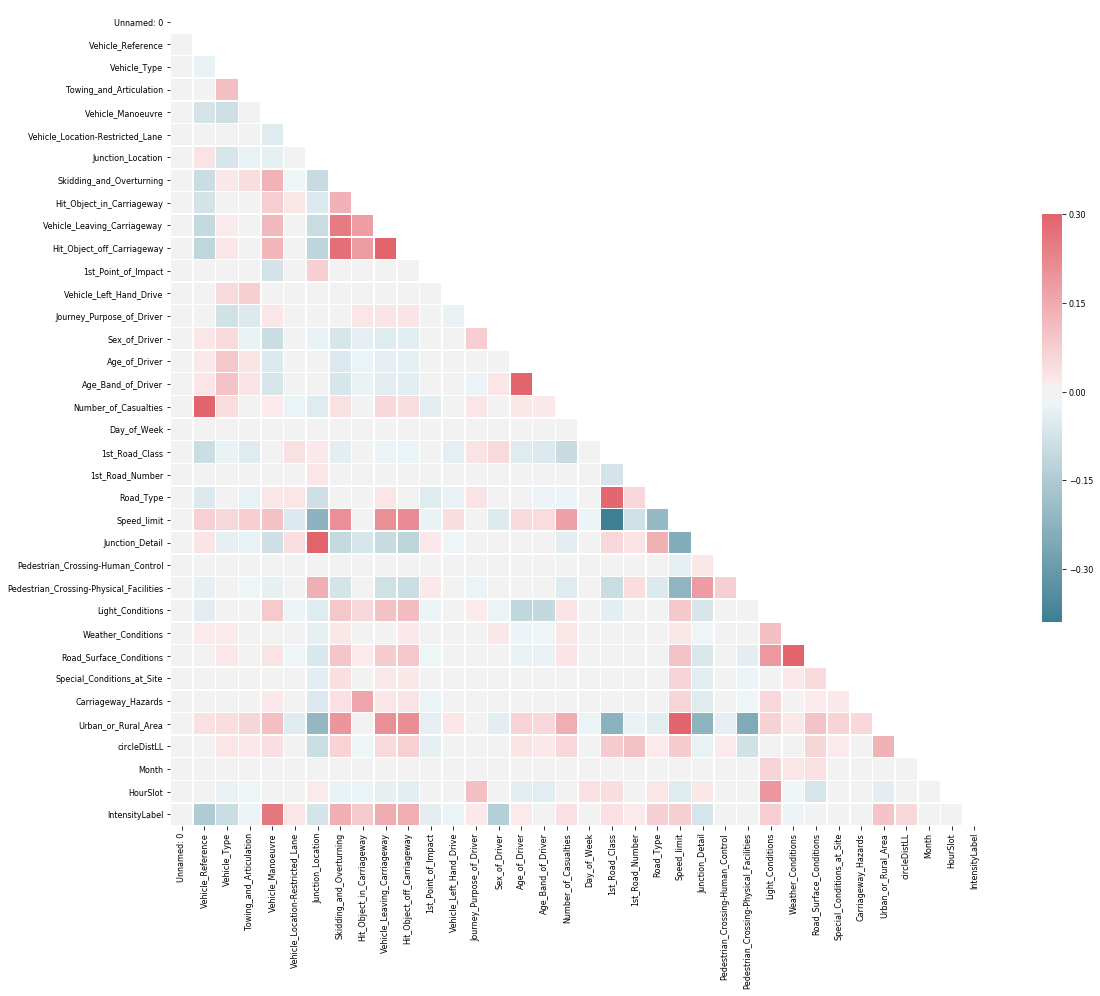

In [17]:
plt.subplots(figsize=(20,15))
corr = modelDataTraining.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [18]:
dataCorrelation = pd.DataFrame(modelDataTraining.corr())
#plt.matshow(data.corr())
def colorPandasDF_redOrGreen(val):
    color = 'red' if val < 0.5 else 'green'
    return 'color: %s' % color
dataCorrelation.style.applymap(colorPandasDF_redOrGreen)

,Unnamed: 0,Vehicle_Reference,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,1st_Point_of_Impact,Vehicle_Left_Hand_Drive,Journey_Purpose_of_Driver,Sex_of_Driver,Age_of_Driver,Age_Band_of_Driver,Number_of_Casualties,Day_of_Week,1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,Junction_Detail,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,circleDistLL,Month,HourSlot,IntensityLabel
Unnamed: 0,1,-0.000633544,-0.00208741,0.00171134,-0.000142661,0.00181848,-0.00313931,0.00600785,-0.00375621,0.00256446,0.00558096,-0.000684994,-0.000889384,0.00373327,-0.000341607,-0.000854679,-0.00171762,0.00540338,0.00139723,0.000364381,0.00178965,-0.000807782,-0.00142129,-0.00122482,0.00223401,-0.000699641,0.000648245,-0.00178629,0.000137909,0.00435924,-0.000874955,-0.00049135,0.00196911,-0.00197687,0.000783646,0.00325238
Vehicle_Reference,-0.000633544,1,-0.0291055,0.000186453,-0.0721546,-0.0134032,0.033152,-0.0920769,-0.0758233,-0.105612,-0.113661,0.00696669,-0.00630493,0.0060052,0.0234753,0.0178791,0.0239755,0.31025,0.00615086,-0.0899817,-0.010046,-0.0575063,0.0691444,0.0291423,-0.00745592,-0.0328131,-0.0426335,0.0152904,-0.0114084,-0.00874129,-0.0106813,0.0368529,-0.0108646,0.00268147,-0.0014469,-0.148913
Vehicle_Type,-0.00208741,-0.0291055,1,0.106701,-0.0826019,0.00970842,-0.0650645,0.0223856,-0.0123614,0.0155484,0.0246368,-0.000828387,0.047102,-0.0780956,0.0490825,0.0884864,0.0974706,0.0450137,0.00380361,-0.0261443,-0.0136928,-0.0121665,0.0574478,-0.0312564,0.00447936,-0.00341482,-0.0011782,0.0151896,0.0200337,0.00427712,0.00112494,0.0426505,0.0272917,-0.000255092,-0.0298823,-0.0963182
Towing_and_Articulation,0.00171134,0.000186453,0.106701,1,0.00132916,0.00114156,-0.0287435,0.0438546,-0.00409158,-0.000719779,0.00630495,0.0146364,0.0746422,-0.0536065,-0.028408,0.0300516,0.0316665,0.00655866,-0.00248235,-0.0470906,-0.012852,-0.0307121,0.0774393,-0.0287103,-0.000554301,-0.0172253,-0.00787873,0.00334033,-0.00604462,0.0067643,0.00301381,0.059385,0.0196906,-0.00095334,-0.0150202,-0.0181234
Vehicle_Manoeuvre,-0.000142661,-0.0721546,-0.0826019,0.00132916,1,-0.045044,-0.0318526,0.13103,0.0786211,0.117018,0.127027,-0.0742813,-0.00657915,0.0243047,-0.0920183,-0.0530868,-0.0644289,0.0159169,-0.0135372,-0.00990933,0.0144158,0.0227696,0.103363,-0.0826251,-0.00163911,-0.0311521,0.0825083,0.000398145,0.0325337,0.00924295,0.0187399,0.108087,0.0413518,0.00406692,0.00166869,0.258798
Vehicle_Location-Restricted_Lane,0.00181848,-0.0134032,0.00970842,0.00114156,-0.045044,1,-0.00372243,-0.015883,0.023838,0.00202667,0.00694755,-0.00582779,-0.00319079,0.00113839,0.0102679,-0.00462508,-0.0102013,-0.0256508,0.00362648,0.03662,-0.000701174,0.0241403,-0.0552675,0.0415454,-0.00147108,-0.00346165,-0.018255,0.00215637,-0.0162078,-0.00633489,-0.00324777,-0.0488159,-0.00362104,0.00234627,-0.00550942,0.0250925
Junction_Location,-0.00313931,0.033152,-0.0650645,-0.0287435,-0.0318526,-0.00372243,1,-0.0986617,-0.0534579,-0.0951371,-0.114689,0.073757,-0.0113311,-0.00162163,-0.0276808,-0.000453804,-0.000736858,-0.0482693,0.0034115,0.0174234,0.0266223,-0.084804,-0.22306,0.523471,0.00263512,0.140311,-0.0475073,-0.0312159,-0.0581241,-0.0402336,-0.0545708,-0.208406,-0.0878519,0.0020608,0.0160518,-0.0702483
Skidding_and_Overturning,0.00600785,-0.0920769,0.0223856,0.0438546,0.13103,-0.015883,-0.0986617,1,0.134369,0.249783,0.275289,0.0113003,-0.000532813,0.0146228,-0.0639218,-0.0561871,-0.0637292,0.035155,-0.0123401,-0.0387466,0.000481782,-0.0140214,0.207382,-0.106318,-0.00702216,-0.0729168,0.0875826,0.0212782,0.0914523,0.0401376,0.0336515,0.195262,0.0657142,-0.00433025,-0.0277319,0.140781
Hit_Object_in_Carriageway,-0.00375621,-0.0758233,-0.0123614,-0.00409158,0.0786211,0.0

#### Set independent and dependent variables

In [19]:
xTraining = modelDataTraining[modelDataTraining.columns.difference(['IntensityLabel'])]
yTraining = modelDataTraining.loc[:, modelDataTraining.columns == 'IntensityLabel']
print('Dataset columns ==> ', xTraining.columns)
print('Dataset label ==> ', yTraining.columns)
print(xTraining.dtypes.value_counts())

Dataset columns ==>  Index(['1st_Point_of_Impact', '1st_Road_Class', '1st_Road_Number',
       'Age_Band_of_Driver', 'Age_of_Driver', 'Carriageway_Hazards',
       'Day_of_Week', 'Hit_Object_in_Carriageway',
       'Hit_Object_off_Carriageway', 'HourSlot', 'Journey_Purpose_of_Driver',
       'Junction_Detail', 'Junction_Location', 'Light_Conditions', 'Month',
       'Number_of_Casualties', 'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Road_Surface_Conditions',
       'Road_Type', 'Sex_of_Driver', 'Skidding_and_Overturning',
       'Special_Conditions_at_Site', 'Speed_limit', 'Towing_and_Articulation',
       'Unnamed: 0', 'Urban_or_Rural_Area', 'Vehicle_Leaving_Carriageway',
       'Vehicle_Left_Hand_Drive', 'Vehicle_Location-Restricted_Lane',
       'Vehicle_Manoeuvre', 'Vehicle_Reference', 'Vehicle_Type',
       'Weather_Conditions', 'circleDistLL'],
      dtype='object')
Dataset label ==>  Index(['IntensityLabel'], dtype='object')
float64   

#### Train-test splitting of input data

In [20]:
xTrain, xTest, yTrain, yTest = train_test_split(xTraining, yTraining, test_size=0.05, random_state=42)
feature_list = list(xTrain.columns)
print(feature_list)

['1st_Point_of_Impact', '1st_Road_Class', '1st_Road_Number', 'Age_Band_of_Driver', 'Age_of_Driver', 'Carriageway_Hazards', 'Day_of_Week', 'Hit_Object_in_Carriageway', 'Hit_Object_off_Carriageway', 'HourSlot', 'Journey_Purpose_of_Driver', 'Junction_Detail', 'Junction_Location', 'Light_Conditions', 'Month', 'Number_of_Casualties', 'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 'Road_Surface_Conditions', 'Road_Type', 'Sex_of_Driver', 'Skidding_and_Overturning', 'Special_Conditions_at_Site', 'Speed_limit', 'Towing_and_Articulation', 'Unnamed: 0', 'Urban_or_Rural_Area', 'Vehicle_Leaving_Carriageway', 'Vehicle_Left_Hand_Drive', 'Vehicle_Location-Restricted_Lane', 'Vehicle_Manoeuvre', 'Vehicle_Reference', 'Vehicle_Type', 'Weather_Conditions', 'circleDistLL']


### Training on 2010-2015 data

#### Random Forest (RF) Classifier implemented with Grid Search and Cross Validation

In [21]:
startTimeRF = datetime.now()
#rf = RandomForestRegressor()
rf = RandomForestClassifier()
param_grid = {
                 'n_estimators': [20],#No. of trees
                 "criterion" : ["gini"]
             }
grid_rf = GridSearchCV(rf, param_grid, cv=3)
grid_rf.fit(xTrain, yTrain)
bestModel = grid_rf.best_estimator_
bestParameters = grid_rf.best_params_
gridScores = grid_rf.grid_scores_
print('Random forest Grid Search with non-redundant variables took [', datetime.now() - startTimeRF, '] seconds.')

Random forest Grid Search with non-redundant variables took [ 0:00:38.734530 ] seconds.


#### Selection of best parameters from Grid Search

In [22]:
print(bestModel)
print(bestParameters)
gridScores

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
{'criterion': 'gini', 'n_estimators': 20}


[mean: 0.72017, std: 0.00094, params: {'criterion': 'gini', 'n_estimators': 20}]

#### Re-training of model with Best parameters from Grid search

In [23]:
startTimeRF = datetime.now()
#rf = RandomForestRegressor(n_estimators = bestParameters.get('n_estimators'),
rf = RandomForestClassifier(n_estimators = bestParameters.get('n_estimators'))
cv = cross_validation.KFold(len(xTrain), n_folds=3, shuffle=True, random_state=2)
cvScores = cross_val_score(rf, xTrain, yTrain, cv=cv)
print ('Mean cross validation score is: ' + str(np.mean(cvScores)))
rf.fit(xTrain, yTrain)
print('Random forest training and testing with with non-redundant variables took [', 
      datetime.now() - startTimeRF, '] seconds.')

Mean cross validation score is: 0.721881416247
Random forest training and testing with with non-redundant variables took [ 0:00:36.722394 ] seconds.


#### Performance evaluation of RF classifier

[1, 0]
Accuracy: 72.99%
Recall: 72.87%
Confusion matrix:
[[4615 1698]
 [1702 4572]]
Area under the ROC curve: 0.270123542956


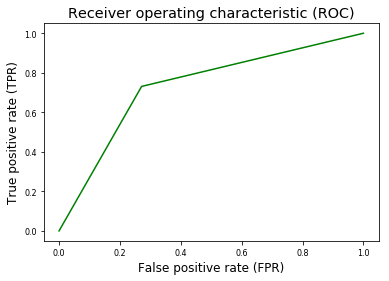

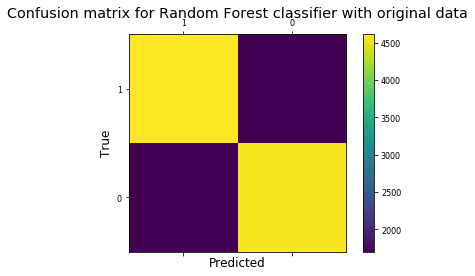

In [24]:
labels = list(modelDataTraining.IntensityLabel.unique())
print(labels)
yPred = rf.predict(xTest)
#print('RF classification score = ', rf.score(xTest, yTest))
cm = confusion_matrix(yTest, yPred, labels)
print('Accuracy: ' + str(np.round(100*float(cm[0][0]+cm[1][1])/float((cm[0][0]+cm[1][1] + cm[1][0] + cm[0][1])),2))+'%')
print('Recall: ' + str(np.round(100*float((cm[1][1]))/float((cm[1][0]+cm[1][1])),2))+'%')
print('Confusion matrix:')
print(cm)

fpr, tpr, _ = roc_curve(yTest, yPred)
auc = np.trapz(fpr,tpr)
print('Area under the ROC curve: ' + str(auc))

fig = plt.figure(1)
plt.plot(fpr,tpr,color='green')
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.title('Receiver operating characteristic (ROC)')

fig = plt.figure(2)
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix for Random Forest classifier with original data')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### Review RF Predictor Importance for feature selection

In [25]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Vehicle_Type         Importance: 0.1
Variable: circleDistLL         Importance: 0.09
Variable: Unnamed: 0           Importance: 0.08
Variable: Age_of_Driver        Importance: 0.07
Variable: 1st_Road_Number      Importance: 0.06
Variable: Vehicle_Manoeuvre    Importance: 0.06
Variable: Month                Importance: 0.05
Variable: Day_of_Week          Importance: 0.04
Variable: Vehicle_Reference    Importance: 0.04
Variable: 1st_Point_of_Impact  Importance: 0.03
Variable: Age_Band_of_Driver   Importance: 0.03
Variable: HourSlot             Importance: 0.03
Variable: Journey_Purpose_of_Driver Importance: 0.03
Variable: Number_of_Casualties Importance: 0.03
Variable: 1st_Road_Class       Importance: 0.02
Variable: Junction_Detail      Importance: 0.02
Variable: Junction_Location    Importance: 0.02
Variable: Road_Type            Importance: 0.02
Variable: Sex_of_Driver        Importance: 0.02
Variable: Skidding_and_Overturning Importance: 0.02
Variable: Speed_limit          I

In [26]:
feature_import = pd.DataFrame(data=rf.feature_importances_, index=xTrain.columns.values, columns=['values'])
feature_import.sort_values(['values'], ascending=False, inplace=True)
feature_import.transpose()

,Vehicle_Type,circleDistLL,Unnamed: 0,Age_of_Driver,Vehicle_Manoeuvre,1st_Road_Number,Month,Day_of_Week,Vehicle_Reference,HourSlot,...,Hit_Object_off_Carriageway,Road_Surface_Conditions,Urban_or_Rural_Area,Hit_Object_in_Carriageway,Vehicle_Location-Restricted_Lane,Special_Conditions_at_Site,Carriageway_Hazards,Towing_and_Articulation,Pedestrian_Crossing-Human_Control,Vehicle_Left_Hand_Drive
values,0.101581,0.0866,0.080363,0.067145,0.062775,0.060296,0.051291,0.042044,0.038212,0.030552,...,0.014446,0.014318,0.009512,0.006949,0.004114,0.003542,0.002775,0.001495,0.00093,0.00058


#### Visualisation of RF Predictor Importance

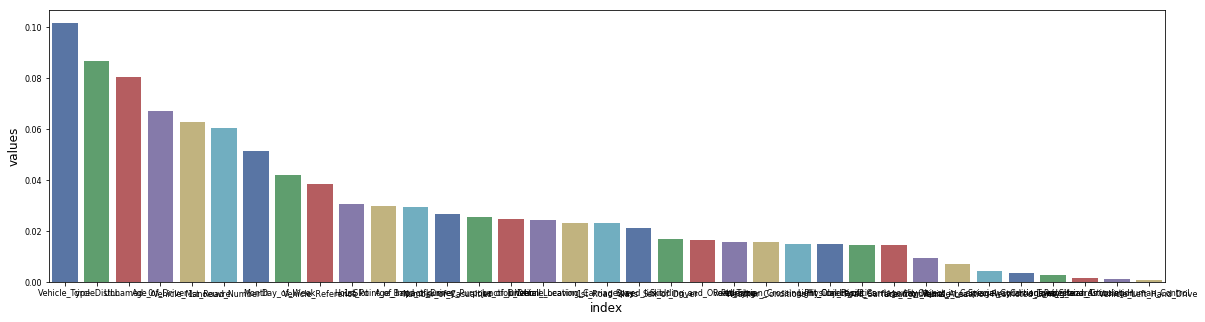

In [27]:
feature_import.reset_index(level=0, inplace=True)
plt.figure(figsize=(20,5))
sns.barplot(x='index', y='values', data=feature_import, palette='deep')
plt.show()

### Testing prediction on 2016 data

In [28]:
csvDataTesting = pd.read_csv("BinarySeverity2016.csv")
print('Sparsity per variable in the dataset ==>')
((len(csvDataTesting.index) - csvDataTesting.count())/len(csvDataTesting.index))#Sparsity per variable retained
csvDataTesting.drop(['LSOA_of_Accident_Location'],axis=1,inplace=True)
csvDataTesting.drop(['Fatal','Serious','Slight','Number_of_Vehicles','Pedestrian_Count'], axis=1, inplace=True)
csvDataTesting.drop(['Accident_Severity','Total Casualities'], axis=1, inplace=True)
modelDataTestingForGeoMapping = csvDataTesting.copy(deep=True)
csvDataTesting.drop(['Latitude','Longitude'],axis=1,inplace=True)
csvDataTesting.reset_index()
predictors = list(csvDataTesting.columns)
print('Total no. of predictors ==> ',len(predictors))
print('Predictors ==> ', predictors)
print('Datatype of variables ==> ')
print(csvDataTesting.dtypes.value_counts())
csvDataTesting.to_csv('datasetForModeling.csv')
print('Printing sample records from dataset ==>')
csvDataTesting.head(2)

Sparsity per variable in the dataset ==>
Total no. of predictors ==>  36
Predictors ==>  ['Unnamed: 0', 'Vehicle_Reference', 'Vehicle_Type', 'Towing_and_Articulation', 'Vehicle_Manoeuvre', 'Vehicle_Location-Restricted_Lane', 'Junction_Location', 'Skidding_and_Overturning', 'Hit_Object_in_Carriageway', 'Vehicle_Leaving_Carriageway', 'Hit_Object_off_Carriageway', '1st_Point_of_Impact', 'Vehicle_Left_Hand_Drive', 'Journey_Purpose_of_Driver', 'Sex_of_Driver', 'Age_of_Driver', 'Age_Band_of_Driver', 'Number_of_Casualties', 'Day_of_Week', '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit', 'Junction_Detail', 'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 'Special_Conditions_at_Site', 'Carriageway_Hazards', 'Urban_or_Rural_Area', 'circleDistLL', 'Month', 'HourSlot', 'IntensityLabel']
Datatype of variables ==> 
float64    26
int64      10
dtype: int64
Printing sample records from d

,Unnamed: 0,Vehicle_Reference,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,...,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,circleDistLL,Month,HourSlot,IntensityLabel
0,0,1,8.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,...,5.0,1.0,1.0,0.0,0.0,1,14.118149,11,1,0
1,1,2,2.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,...,5.0,1.0,1.0,0.0,0.0,1,14.118149,11,1,0


In [29]:
xTesting = csvDataTesting[csvDataTesting.columns.difference(['IntensityLabel'])]
yTesting = csvDataTesting.loc[:, csvDataTesting.columns == 'IntensityLabel']
print('Dataset columns ==> ', xTesting.columns)
print('Dataset label ==> ', yTesting.columns)
print(xTesting.dtypes.value_counts())

Dataset columns ==>  Index(['1st_Point_of_Impact', '1st_Road_Class', '1st_Road_Number',
       'Age_Band_of_Driver', 'Age_of_Driver', 'Carriageway_Hazards',
       'Day_of_Week', 'Hit_Object_in_Carriageway',
       'Hit_Object_off_Carriageway', 'HourSlot', 'Journey_Purpose_of_Driver',
       'Junction_Detail', 'Junction_Location', 'Light_Conditions', 'Month',
       'Number_of_Casualties', 'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Road_Surface_Conditions',
       'Road_Type', 'Sex_of_Driver', 'Skidding_and_Overturning',
       'Special_Conditions_at_Site', 'Speed_limit', 'Towing_and_Articulation',
       'Unnamed: 0', 'Urban_or_Rural_Area', 'Vehicle_Leaving_Carriageway',
       'Vehicle_Left_Hand_Drive', 'Vehicle_Location-Restricted_Lane',
       'Vehicle_Manoeuvre', 'Vehicle_Reference', 'Vehicle_Type',
       'Weather_Conditions', 'circleDistLL'],
      dtype='object')
Dataset label ==>  Index(['IntensityLabel'], dtype='object')
float64   

#### Classifier performance on Hold-out test set from 2016 data

##### ROC curve and Confusion matrix

Accuracy: 72.06%
Recall: 72.13%
Confusion matrix:
[[ 16017   6425]
 [ 59427 153828]]
Area under the ROC curve: 0.270123542956


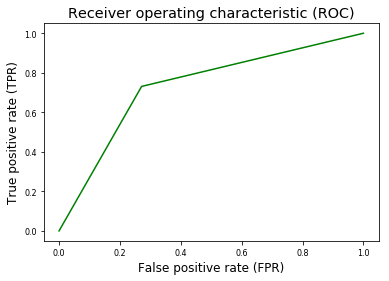

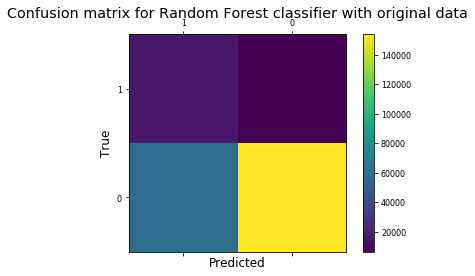

In [30]:
yPredTesting = rf.predict(xTesting)
#print('RF classification score = ', rf.score(xTesting, yTesting))
cm = confusion_matrix(yTesting, yPredTesting, labels)
print('Accuracy: ' + str(np.round(100*float(cm[0][0]+cm[1][1])/float((cm[0][0]+cm[1][1] + cm[1][0] + cm[0][1])),2))+'%')
print('Recall: ' + str(np.round(100*float((cm[1][1]))/float((cm[1][0]+cm[1][1])),2))+'%')
print('Confusion matrix:')
print(cm)

fpr, tpr, _ = roc_curve(yTest, yPred)
auc = np.trapz(fpr,tpr)
print('Area under the ROC curve: ' + str(auc))

fig = plt.figure(1)
plt.plot(fpr,tpr,color='green')
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.title('Receiver operating characteristic (ROC)')

fig = plt.figure(2)
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix for Random Forest classifier with original data')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

##### F-score

In [31]:
print('Classifier performance ==> \n',classification_report(yTesting, yPredTesting))

Classifier performance ==> 
              precision    recall  f1-score   support

          0       0.96      0.72      0.82    213255
          1       0.21      0.71      0.33     22442

avg / total       0.89      0.72      0.78    235697



In [32]:
actualGeoMapping = modelDataTestingForGeoMapping.copy(deep=True)
actualGeoMapping = actualGeoMapping.loc[:,['Latitude','Longitude','IntensityLabel']]
predictedGeoMapping = modelDataTestingForGeoMapping.copy(deep=True)
predictedGeoMapping = predictedGeoMapping.loc[:,['Latitude','Longitude']]
predictedGeoMapping['IntensityLabel'] = pd.Series(yPredTesting)

In [33]:
geoMapping = actualGeoMapping['IntensityLabel'].isin(predictedGeoMapping['IntensityLabel']).astype(int)
print('Match percentage = ',((sum(geoMapping)/len(geoMapping))*100),'%')

Match percentage =  100.0 %


#### Visualisation of predicted and actual hotspots for 2016

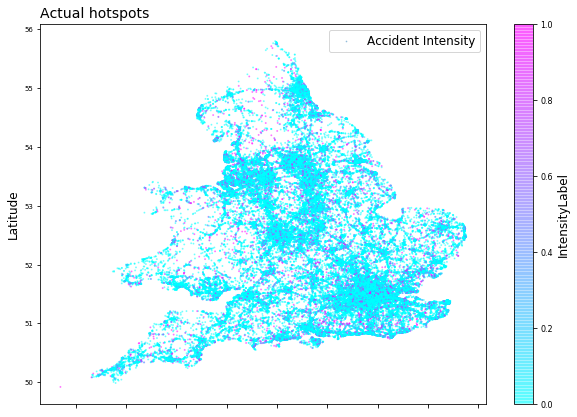

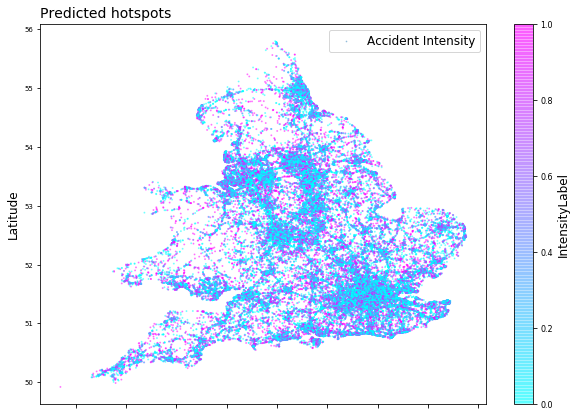

In [34]:
plt.figure(figsize=(15,15))
actualGeoMapping.plot(kind="scatter", x="Longitude", y="Latitude",
    s=actualGeoMapping['IntensityLabel'].unique().tolist(),
    label="Accident Intensity",
    c="IntensityLabel", cmap=plt.get_cmap("cool"),
    #c="Accident_Severity", cmap=cmap,
    colorbar=True, alpha=0.4, figsize=(10,7),
)
plt.legend()
plt.title('Actual hotspots',loc='left',fontsize=14)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.show()

predictedGeoMapping.plot(kind="scatter", x="Longitude", y="Latitude",
    s=predictedGeoMapping['IntensityLabel'].unique().tolist(),
    label="Accident Intensity",
    c="IntensityLabel", cmap=plt.get_cmap("cool"),
    #c="Accident_Severity", cmap=cmap,
    colorbar=True, alpha=0.4, figsize=(10,7),
)
plt.legend()
plt.title('Predicted hotspots',loc='left',fontsize=14)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.show()

<font color='red'>1) Classifier seems to be more biased towards High Intensity class. This is due to more weightage for severity in the derived label.</font> <font color='green'> 2) Extensive grid search shall improve performance substantially. Not much training was done due to lengthy training time. 3) Use of SMOTE instead of undersampling shall help in using more data from Low Intensity class. This is highly likely to improve performance</font>

In [35]:
print('Overall execution took [', datetime.now() - startTime, '] seconds.')

Overall execution took [ 0:02:06.377620 ] seconds.
